In [1]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# execute command below for install itables (interactive python dataframes)
#!pip install itables

In [3]:
from itables import show

<IPython.core.display.Javascript object>

### Get data in JSON format

In [4]:
data = requests.get("https://justjoin.it/api/offers")

### Parse data and expand skill column

In [5]:
df = pd.DataFrame()
print(f"total: {len(data.json())}")
for row in data.json():
    skills = row.get("skills",[])
    for skill in skills:
        row["skill_"+skill.get("name")] = skill.get("level")
    df = df.append(row, ignore_index=True )
    print("x", end="")

total: 1053
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

### Prepare and convert the data

In [6]:
df.salary_from = df.salary_from.astype('float')
df.salary_to = df.salary_to.astype('float')
df.remote = df.remote.astype('int')
df.city = df.city.str.upper()
df.rename(columns={"marker_icon":"technology"}, inplace=True)
df.title = df.title.str.upper()
for col in df.columns.str.startswith("skill_"):
    df.replace(pd.np.NaN, 0, inplace=True)

### Choose columns

In [7]:
cols = [ 'id','title', 'city', 'company_name',
       'company_size', 'country_code', 'employment_type',
       'experience_level', 'technology',
       'published_at', 'remote', 'salary_currency', 'salary_from', 'salary_to',
       ]
cols.extend( list(df.columns[df.columns.str.startswith("skill_")]) )
df =df[cols]

column = df.pop('salary_from')
df.insert(2, column.name, column)

column = df.pop('salary_to')
df.insert(3, column.name, column)

sal_avg = (df.salary_from + df.salary_to)/2
df.insert(4, 'salary_avg', sal_avg)

In [8]:
"""
df_result = df[(df.title.str.contains('PYTHON')) & 
               (df.employment_type=="b2b") & 
               (df.city.str.contains('WARSZAWA')) ]
"""

# only B2B offers
df_result = df[(df.employment_type=="b2b")]


In [9]:
# show all columns except starting with 'skill_' phrase
show(df_result[ [c for c in df_result if not c.startswith('skill_')] ], maxBytes=0)
# looking for announcement link? append 'id' value to https://justjoin.it/offers/ 

,id,title,salary_from,salary_to,salary_avg,city,company_name,company_size,country_code,employment_type,experience_level,technology,published_at,remote,salary_currency


### Liczba ogłoszeń w poszczególnych technologiach

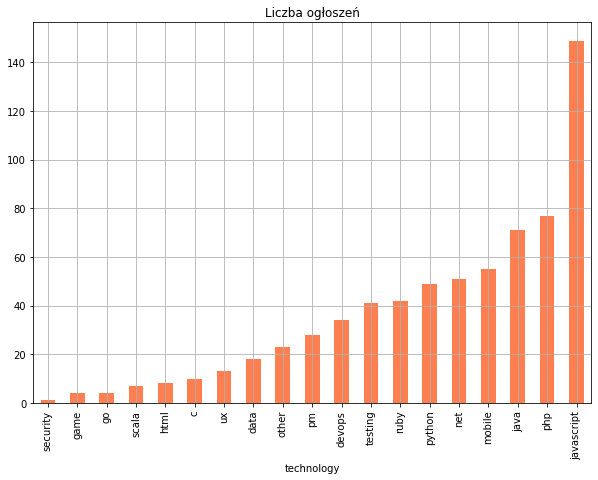

In [10]:
df_result.groupby('technology')["id"].count().sort_values().plot(kind='bar', color='coral',
                                                figsize=(10,7), grid=True, 
                                                title='Liczba ogłoszeń')
plt.show()

### Mediana wynagrodzeń w poszczególnych technologiach (B2B)

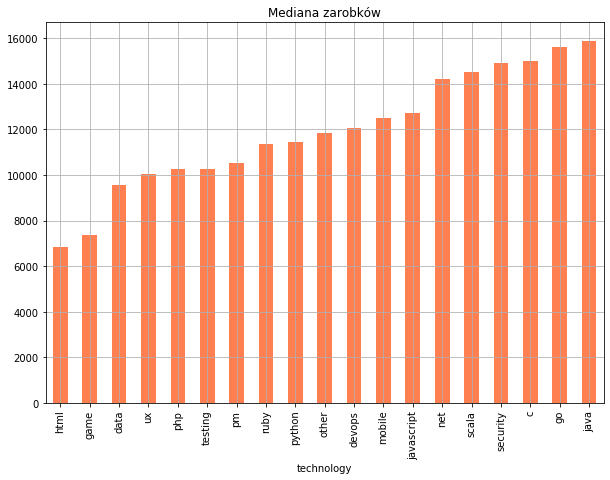

In [11]:
df_result.groupby('technology')["salary_avg"].mean().sort_values().plot(kind='bar', color='coral',
                                                figsize=(10,7), grid=True, 
                                                title='Mediana zarobków')
plt.show()

### TOP 10 miast

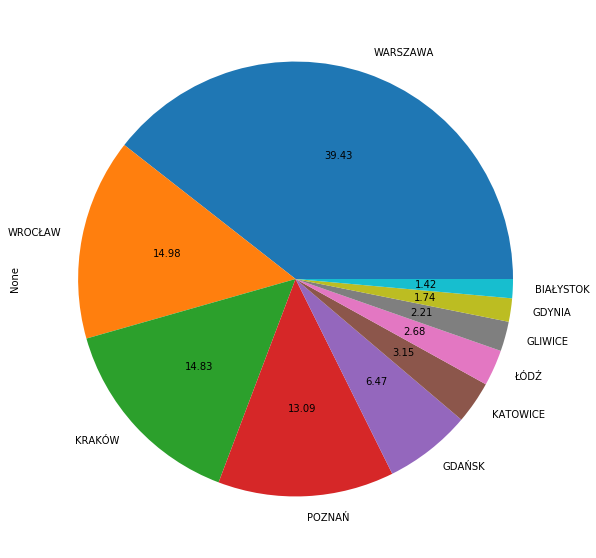

In [12]:
df_result.groupby('city').size().\
    sort_values(ascending=False).head(10).plot.pie(figsize=(10,10), autopct='%.2f')

### Rozkład średniego wynagrodzenia dla ogłoszeń w 10 najpopularniejszych technologiach

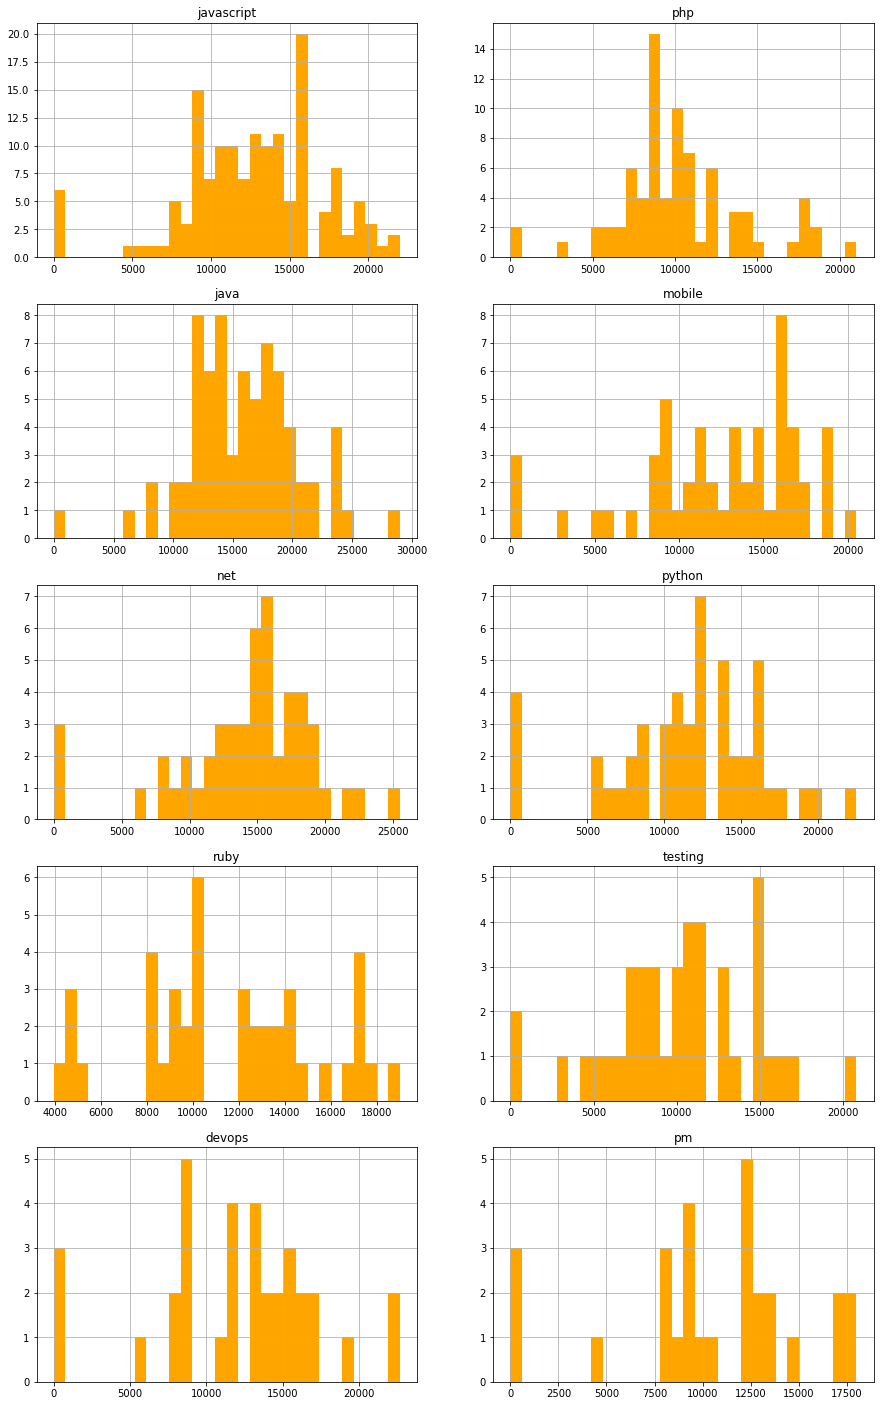

In [13]:
techs = list(df_result.groupby('technology')["id"].count().\
             sort_values(ascending=False).head(10).index)

plt.figure(figsize=(15,25))
for i in range(len(techs)):
    plt.subplot(5, 2, i+1)
    df_result[df_result.technology==techs[i]].\
        salary_avg.hist(bins=30, color='orange')
    plt.title(techs[i])